In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram
from scipy.ndimage import gaussian_filter1d

# functions for signal processing
def gain_compensation(data, gain):
    linear_gain = 10 ** (gain / 20)
    calibrated_data = data / linear_gain
    return calibrated_data

def time_avg_freq_spectrum(data, fs, nperseg=2048):
    f, t, Sxx = spectrogram(data, fs, nperseg=nperseg)
    # average spectrum over time
    cols = np.arange(len(t))
    spec_avg = Sxx[:, cols].mean(axis=1)
    spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2
    return f, spec_sm

def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band') # get filter coefficients
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def filtering_and_amplification(data, fs, lowcut, highcut):
    # first filter and amplification
    filt1 = bandpass_filter(data, fs, lowcut, highcut)
    filt2 = filt1 * 20 
    # second filter and amplification
    filt3 = bandpass_filter(filt2, fs, lowcut, highcut)
    filt_def = filt3 * 10
    return filt_def

def envelope_extraction(data):
    analytic_signal = hilbert(data)
    envelope = np.abs(analytic_signal)
    return envelope

def rectangular_waveform(envelope, gains, time_array):
    threshold = 2 # volts
    # first column of results is the time index of detected impulses
    rect_hilbert = pd.DataFrame({'time': time_array})
    # loop over channels, apply gain, and detect impulses
    for ch, gain in gains.items():
        amplified = envelope * gain
        # create binary array: 1 if in threshold, else 0
        binary = ((amplified > threshold)).astype(int)
        # convert to 5 V pulse
        rectangular = binary * 5
        rect_hilbert[f'ch{ch}'] = rectangular
    return rect_hilbert

def count_impulses(rectangular, time, gains):
    dt = 1.0 # target bin size in seconds
    # build bins
    time_bins = np.arange(time[0], time[-1] + dt, dt) # include last bin edge
    time_index = pd.to_timedelta(time_bins[:-1], unit="s") # exclude last edge for index
    # prepare output array
    results = pd.DataFrame(index=time_index)
    # loop over channels
    for ch, gain in gains.items():
        rect_signal = rectangular[f"ch{ch}"].values
        # detect rising edges: 0→5 transitions
        rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
        edge_times = time[1:][rising_edges]
        # bin counts into 1 s intervals
        counts, _ = np.histogram(edge_times, bins=time_bins)
        results[f"impulses_ch{ch}"] = counts
    return results

def quantify_impacts(results, envelope, rectangular, time, gains, file_name):
    # 1. add the original envelope as 'hilbert' column
    env_series = pd.Series(envelope, index=pd.to_timedelta(time, unit="s"))
    results["hilbert"] = env_series.resample("1s").mean()

    # 2. add rectangular waveforms and envelopes (resampled to 1 Hz)
    for ch in gains.keys(): 
        rect_series = pd.Series(rectangular[f"ch{ch}"].values, index=pd.to_timedelta(time, unit="s"))
        results[f"rect_ch{ch}"] = rect_series.resample('1s').max() # use max to keep 5V pulses
        # add per channel envelopes (amplified by gain)
        env_series = pd.Series(envelope * gains[ch], index=pd.to_timedelta(time, unit="s"))
        results[f"env_ch{ch}"] = env_series.resample("1s").mean()

    # 3. define analysis window (entire recording)
    t0 = time.min()  # start of entire period
    t1 = time.max()  # end of entire period
    window = results

    # 4. compute summary statistics over entire period
    impulse_sums = window.filter(like="impulses_ch").sum() # sum impulses per channel over entire period
    # amplitude stats (full envelope during entire period)
    max_amp = window["hilbert"].max()
    mean_amp = window["hilbert"].mean()
    median_amp = window["hilbert"].median()

    # 5. parse file name for date and time 
    base_name = os.path.basename(file_name).replace('.flac', '')  # remove extension
    date_time_part = base_name.split('_')[1]  # get "MMDDYY-HHMMSS"
    date_part, time_part = date_time_part.split('-')  # split into date and time
    # format date: MMDDYY -> MM/DD/YY
    formatted_date = f"{date_part[:2]}/{date_part[2:4]}/{date_part[4:]}"
    # format time: HHMMSS -> HH:MM:SS
    formatted_time = f"{time_part[:2]}:{time_part[2:4]}:{time_part[4:]}"
    # combine date and time
    datetime_string = f"{formatted_date} {formatted_time}"
    # collect results
    summary = {
        "time": datetime_string,
        "max_amp": max_amp,
        "mean_amp": mean_amp,
        "median_amp": median_amp
    }
    summary.update(impulse_sums.to_dict())  # add channel impulse counts

    # 6. calculate max, mean and median envelope only during impulses 
    for ch in gains.keys():
        impulse_mask = window[f"rect_ch{ch}"] > 0  # mask for times with impulses
        if impulse_mask.any():
            max_env = window.loc[impulse_mask, f"env_ch{ch}"].max()
            mean_env = window.loc[impulse_mask, f"env_ch{ch}"].mean()
            median_env = window.loc[impulse_mask, f"env_ch{ch}"].median()
        else:
            max_env = mean_env = median_env = 0  # no impulses detected
        summary[f"max_env_ch{ch}"] = max_env
        summary[f"mean_env_ch{ch}"] = mean_env
        summary[f"median_env_ch{ch}"] = median_env
    return summary

gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

def storm_processing(folder, preamp_gain, storm_number, preamp_channel):
    """Folder is a string, preamp_gain is in dB (int), 
    storm_number is a string for labeling and preamp_channel is 0 for left or 1 for right channel"""

    all_results = []  # List to store results from each file
    skipped_files = []  # Track files that couldn't be processed
    # loop through all the files in the folder
    for file in os.listdir(folder):
        if file.endswith('.flac'):
            file_path = os.path.join(folder, file)
            try:
                raw_data, fs = sf.read(file_path)
                # select pipe channel (0 for left, 1 for right)
                selected_channel = raw_data[:, preamp_channel]
                # gain compensation
                data = gain_compensation(selected_channel, preamp_gain)
                time = np.arange(len(data)) / fs # time vector
                # get averaged frequency spectrum
                frequencies, spectrum = time_avg_freq_spectrum(data, fs)
                # filter and amplify signal
                filtered_data = filtering_and_amplification(data, fs, 700, 1500)
                # extract envelope
                envelope = envelope_extraction(filtered_data)
                # rectangular waveform
                rectangular = rectangular_waveform(envelope, gains, time)
                # count impulses
                results = count_impulses(rectangular, time, gains)
                # quantify impacts and summarize metrics
                final = quantify_impacts(results, envelope, rectangular, time, gains, file_path)
                # append this file's results to the list
                all_results.append(final)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                skipped_files.append(file_path)
                continue
    # convert list of dictionaries to DataFrame
    df_compiled = pd.DataFrame(all_results)
    # transpose to have metrics as index and files as columns
    df_compiled = df_compiled.set_index('time').T
    # Add storm number as metadata (optional)
    df_compiled.name = f"{storm_number}"
    return df_compiled

### Summer Storm 2 vs Storm 4 

In [ ]:
storm2_name = 'st2/raspberrypi_080322-124600.flac'
storm4_name = 'st4/raspberrypi_072923-124500.flac'
flood3_name =  '../Calibration/EXP-09-20-23-FLOW3/audio/Nicole_091823-000100.flac'

st2_raw_data, fs = sf.read(storm2_name) # sampling frequency is the same
st4_raw_data, fs = sf.read(storm4_name)
flood3_raw_data, fs = sf.read(flood3_name)

# select channel gain for each storm
if st2_raw_data.ndim > 1:
    st2_raw_data = st2_raw_data[:,1] # right channel

if st4_raw_data.ndim >1:
    st4_raw_data = st4_raw_data[:,0] # left channel

if flood3_raw_data.ndim > 1:
    flood3_raw_data = flood3_raw_data[:,0] # left channel

# gain compensation
st2 = gain_compensation(st2_raw_data, 30) 
st4 = gain_compensation(st4_raw_data, 23)
flood3 = gain_compensation(flood3_raw_data, 23)

# time vector
st2_time = np.arange(len(st2)) / fs
st4_time = np.arange(len(st2)) / fs
flood3_time = 
# they are the same, so: 
time = st2_time

44100
44100


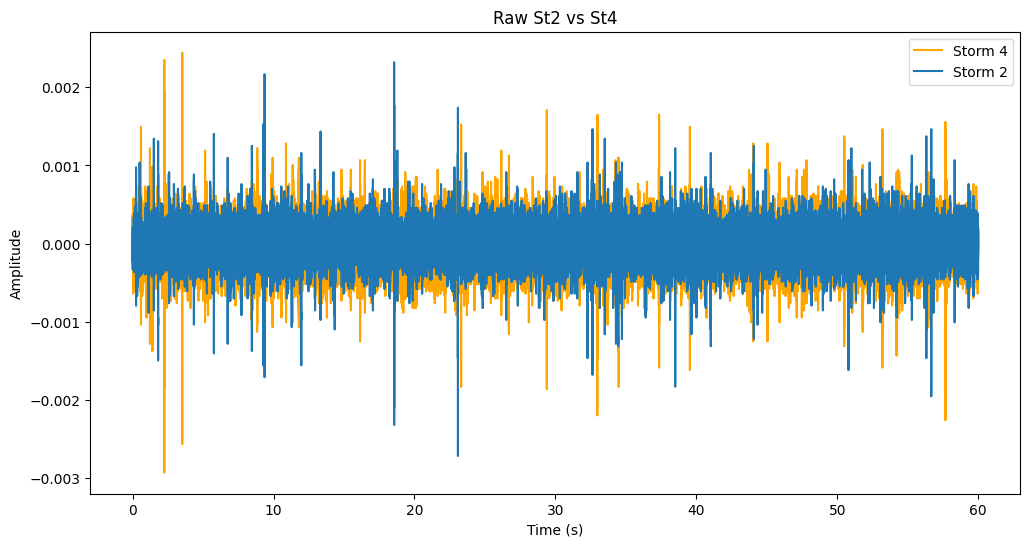

In [50]:
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))

plt.plot(time, st4_raw_data, label="Storm 4", color='orange')
plt.plot(time, st2_raw_data, label="Storm 2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw St2 vs St4")
plt.legend(loc='upper right')
#plt.xlim(33.107,33.115)
plt.show()

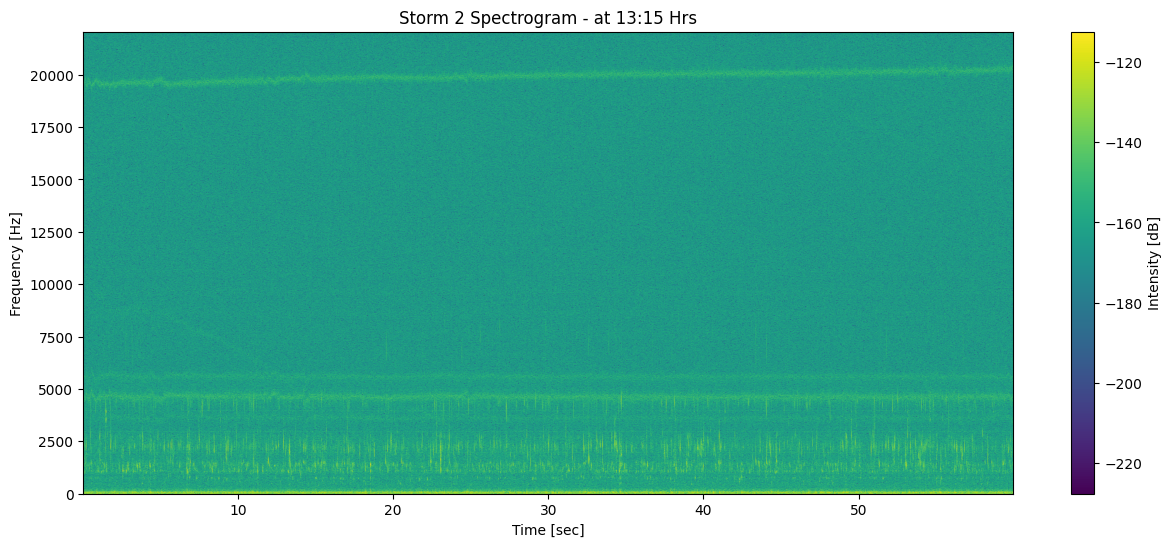

In [51]:
freq2, t2, Sxx2 = spectrogram(st2, fs, nperseg=2048)

plt.figure(figsize=(15, 6))
plt.pcolormesh(t2, freq2, 10 * np.log10(Sxx2), shading='gouraud')
plt.colorbar(label='Intensity [dB]') 
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Storm 2 Spectrogram - at 13:15 Hrs')
plt.ylim([0, fs / 2])  # limit y-axis to Nyquist frequency
plt.show()

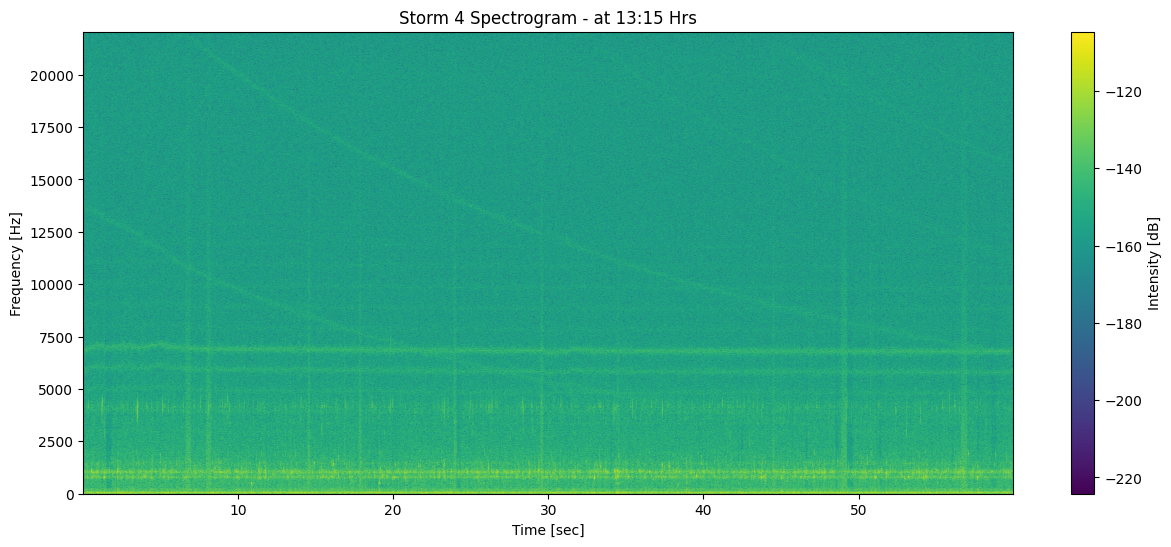

In [52]:
freq4, t4, Sxx4 = spectrogram(st4, fs, nperseg=2048)

plt.figure(figsize=(15, 6))
plt.pcolormesh(t4, freq4, 10 * np.log10(Sxx4), shading='gouraud')
plt.colorbar(label='Intensity [dB]') 
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Storm 4 Spectrogram - at 13:15 Hrs')
plt.ylim([0, fs / 2])  # limit y-axis to Nyquist frequency
plt.show()

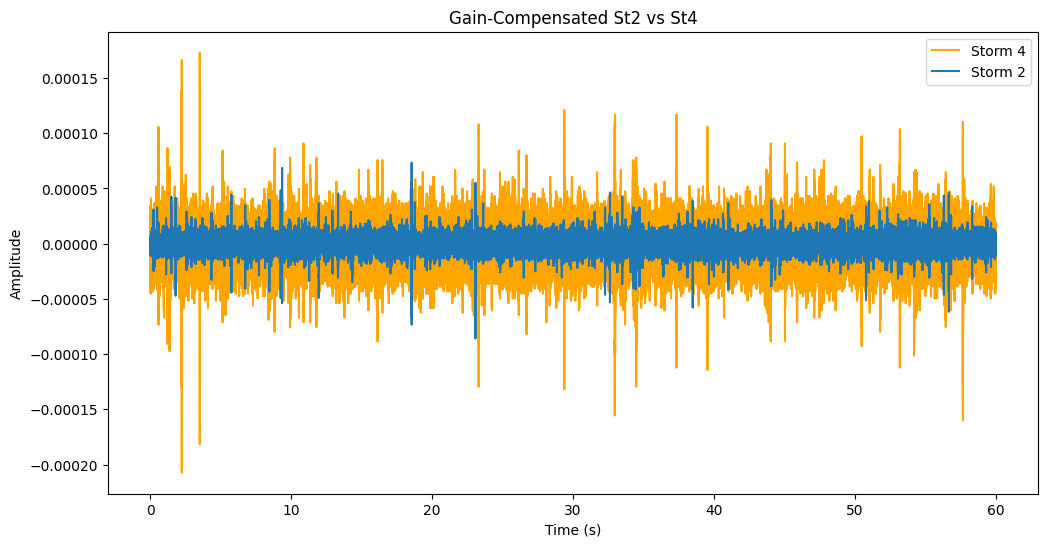

In [ ]:
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, st4, label="Storm 4", color='orange')
plt.plot(time, st2, label="Storm 2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Gain-Compensated Signals at Baseflow")
plt.legend(loc='upper right')
#plt.xlim(33.107,33.115)
#plt.ylim(-0.0005, 0.0005)
plt.show()

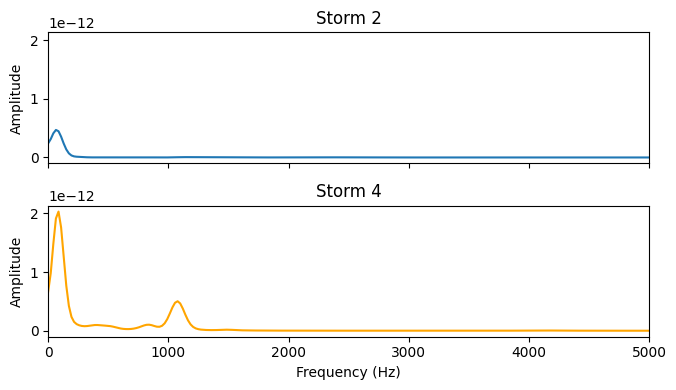

In [47]:
frequencies2, spectrum2 = time_avg_freq_spectrum(st2, fs)
frequencies4, spectrum4 = time_avg_freq_spectrum(st4, fs)

fig, axes = plt.subplots(2, 1, figsize=(7, 4), sharex=True, sharey=True)

# First spectrum
axes[0].plot(frequencies2, spectrum2)
axes[0].set_xlim(0, 5000)
#axes[0].set_ylim(0, 10**-14)
axes[0].set_title("Storm 2")
axes[0].set_ylabel("Amplitude")

# Second spectrum
axes[1].plot(frequencies4, spectrum4, color='orange')
axes[1].set_xlim(0, 5000)
#axes[1].set_ylim(0, 10**-11)
axes[1].set_title("Storm 4")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()
